Линейная регрессия (1D)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import patsy as pt
import random as rand

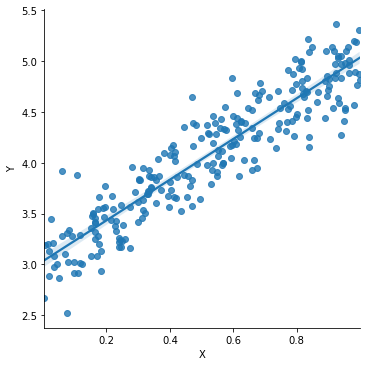

In [2]:
a = 2
b = 3
X = np.random.rand(256)

noise = np.random.randn(256) / 4

Y = a*X+b+noise

df = pd.DataFrame()
df['X'] = X
df['Y'] = Y

sns.lmplot(x ='X', y ='Y', data = df)

In [3]:
class LinearRegression():
    def __init__(self, learning_rate=0.0001, iterations = 100000):
        self.a = 0
        self.b = 0
        self.learning_rate = learning_rate
        self.iterations = iterations
    
    def fit(self, X, Y):
        a = self.a
        b = self.b
        learning_rate = self.learning_rate
        n = float(len(X))
        iterations = self.iterations
        
        for i in range(iterations): 
            self.a = a + (2/n) * learning_rate * np.sum(X * (Y - (a*X + b)))
            self.b = b + (2/n) * learning_rate * np.sum(Y - (a*X + b))

    def coef(self):
        return self.a, self.b
    
    def predict(self, X):
        return self.a * X + self.b

In [4]:
linearReg = LinearRegression()
linearReg.fit(X,Y)
linearReg.coef()

(0.00046114020763033515, 0.0008165091618187071)

Логистическая регрессия (2D)

In [5]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [6]:
X,Y = make_blobs(n_samples=200,centers=2,random_state=64)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

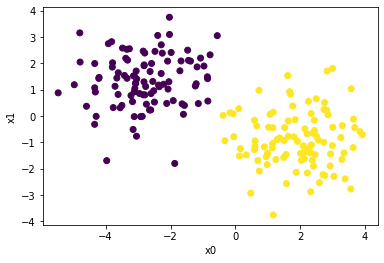

In [7]:
plt.scatter(X[:,0],X[:,1],c=Y)
plt.xlabel("x0")
plt.ylabel("x1")
plt.show()

In [8]:
class LogisticRegression():
    
    def __init__(self, lr=0.01, max_iter=1000):
        self.lr = lr
        self.epochs = max_iter
    
    def sigmoid(self, z):    
        return 1/(1+np.exp(-z))  
    
    def cost(self,w, X, y):
        h = np.dot(X, w)
        m = len(X)       
        if(self.activate_fn != None):  h = self.activate_fn(h)
        loss= (np.dot(-y, np.log(h))) - (np.dot(1-y, np.log(1-h)))
        loss = np.sum(loss)/m
        
        if(self.reg):           
            loss = loss + ((self.lr/2*m) * np.sum(np.power(w,2)))
        return loss
    
    def fit(self, X, Y):
        X = np.c_[X, np.ones(X.shape[0])]    
        w = np.random.rand(X.shape[1])
        N = len(X)
                 
        for _ in range(self.epochs):        
            Y_pred = self.sigmoid(np.dot(X, w))
            w -= self.lr * np.dot(X.T,  Y_pred - Y) / N
            
        self.w = w
    
    def predict(self, X):
        X = np.c_[X, np.ones(X.shape[0])] 
        z = np.dot(X, self.w)
        return [1 if i > 0.5 else 0 for i in self.sigmoid(z)]
    
    def predict_proba(self, X):
        X = np.c_[X, np.ones(X.shape[0])] 
        z = np.dot(X, self.w)
        return np.array((self.sigmoid(z),1-self.sigmoid(z))).T

In [9]:
log_reg = LogisticRegression()
log_reg.fit(X_train,Y_train)
Y_pred = log_reg.predict(X_test)
print('Accuracy: ',np.mean(Y_pred==Y_test))

Accuracy:  1.0


[(-6.0, 5.0), (-10.0, 10.0)]

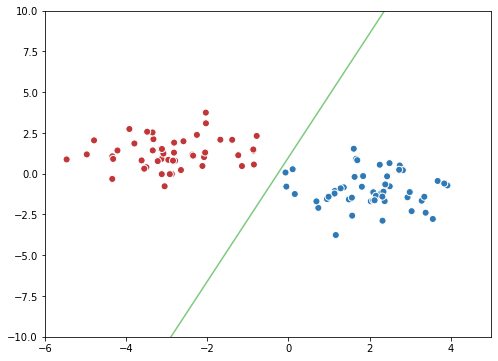

In [10]:
xx, yy = np.mgrid[-50:50:.1, -50:50:.1]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = log_reg.predict_proba(grid)[:, 1].reshape(xx.shape)

f, ax = plt.subplots(figsize=(8, 6))
ax.contour(xx, yy, probs, levels=[.5], cmap="Accent", vmin=0, vmax=10000)

ax.scatter(X[100:,0], X[100:, 1], c=Y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlim=(-6, 5), ylim=(-10, 10))

Дерево принятия решений (2D)

In [11]:
import math

In [15]:
class Node:

    def __init__(self, x, y, idxs, min_leaf=5):
        self.x = x 
        self.y = y
        self.idxs = idxs 
        self.min_leaf = min_leaf
        self.row_count = len(idxs)
        self.col_count = x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()
        
    def find_varsplit(self):
        for c in range(self.col_count): self.find_better_split(c)
        if self.is_leaf: return
        x = self.split_col
        lhs = np.nonzero(x <= self.split)[0]
        rhs = np.nonzero(x > self.split)[0]
        self.lhs = Node(self.x, self.y, self.idxs[lhs], self.min_leaf)
        self.rhs = Node(self.x, self.y, self.idxs[rhs], self.min_leaf)
        
    def find_better_split(self, var_idx):
      
        x = self.x[self.idxs, var_idx]

        for r in range(self.row_count):
            lhs = x <= x[r]
            rhs = x > x[r]
            if rhs.sum() < self.min_leaf or lhs.sum() < self.min_leaf: continue

            curr_score = self.find_score(lhs, rhs)
            if curr_score < self.score: 
                self.var_idx = var_idx
                self.score = curr_score
                self.split = x[r]
                
    def find_score(self, lhs, rhs):
        y = self.y[self.idxs]
        lhs_std = y[lhs].std()
        rhs_std = y[rhs].std()
        return lhs_std * lhs.sum() + rhs_std * rhs.sum()
                
    @property
    def split_col(self): return self.x[self.idxs,self.var_idx]
                
    @property
    def is_leaf(self): return self.score == float('inf')                

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        node = self.lhs if xi[self.var_idx] <= self.split else self.rhs
        return node.predict_row(xi)

In [19]:
class DecisionTreeRegressor:
  
  def fit(self, X, y, min_leaf = 5):
    self.dtree = Node(X, y, np.array(np.arange(len(y))), min_leaf)
    return self
  
  def predict(self, X):
    return self.dtree.predict(X)

In [22]:
clf = DecisionTreeRegressor()
clf.fit(X_train, Y_train)

Y_pred = clf.predict(X_test)
print('Accuracy: ',np.mean(Y_pred==Y_test))

Accuracy:  1.0
